<p align="center">
    <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780081002858000055-f05-13-9780081002858.jpg" width="220" height="240" />

</p>

# Final Product - Rod Pump Optimization

## Inventors Program Energy - NSC 325

#### Written by: Nicholas Khami, Nashra Ali, Vrishank Jannu

This notebook presents an implementation of a Random Forest Regression to predict the timing of a sucker rod pump failure. The data used for building the following model is provided by ConocoPhillips. The aim of this product is to assist production engineers in hypothesizing a better design for the downhole set-up in order to extend pump lifetimes. Thus, the company can cut yearly maintainence costs (i.e. part replacement) and consequently see an increase oil production per well. This benefits the company in guranteeing a higher return on their investments. 


### Imports

We import the packages that will be necessary for creating our model


In [2]:
import glob
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression



## Exploring Data Analysis and Cleanup

To begin approaching the problem, it is important to get a feel for the data that we will be working with. The following code displays the head of the data and dataframe properties. The data documents mechanical and chemical parameters of various sucker rod pumps owned by ConocoPhillips.


In [3]:
rpdf = pd.read_csv("../UT_RodPump_Dataset/rodpump_failure.csv")
rpdf.head()

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,...,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,DESANDDEGAS_TYP,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH,pump_bore,gasanchor_od
0,GB27GKBE51029074693667,175-58-0111,box-child-doctor,GPVO63973435661154,GB55QFGB46756147811400,2014-05-02 00:00:00.000,2019-01-04 10:00:00.000,FGNB86581338411987,Tubing,2018-12-11 00:00:00.000,...,NaN,NaN,NaN,UNKNOWN,0.0,0.00,0.0,10024.8,1.5,NaN
1,GB53OEVX46438297645035,333-68-3523,outside-worry,ZAYT33358197650329,GB29QCCC14341267287129,2018-01-28 14:00:00.000,2019-05-17 12:00:00.000,XRYU81281518151403,Tubing,2019-04-01 00:00:00.000,...,179.44,179.44,179.44,Miller LLC,0.0,0.00,0.0,10235.6,1.5,3.5
2,GB95BPWW35640301552066,165-51-5897,near-learn-simply,FNVL11432909873086,GB02DJAW44801752494129,2011-09-14 00:00:00.000,2012-08-20 00:00:00.000,PLPR44121073149707,Sucker Rod Pump,2012-08-01 00:00:00.000,...,105.76,105.76,105.76,Miller LLC,0.0,0.00,0.0,10401.9,1.5,NaN
3,GB79UEDN31454825972680,543-56-3494,sea-improve-place,JOKL33317998159514,GB84GHPH97287631470412,2016-01-12 09:00:00.000,2017-03-16 16:30:00.000,MYCF04792093856141,Sucker Rod Pump,2017-01-19 00:00:00.000,...,98.18,47.96,98.18,Miller LLC,0.0,0.00,0.0,9557.7,1.75,4.5
4,GB20XCTM13691331349509,391-37-2039,personal-candidate,XOSU92041716672870,GB08VYTX61977431827206,2018-06-14 13:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,NaN,NaN,...,266.68,266.68,170.99,Miller LLC,0.0,129.39,0.0,9681.7,1.75,NaN



We now want to look at the summary statistics for each numeric feature and unique counts for the categorical features to give us an idea of what features may be important to keep.

### Numeric Summaries


In [4]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', 55)
rpdf_numeric_summary = rpdf.describe()
rpdf_numeric_summary

,H2S_CONCENTRATION,PrimarySetpoint,SecondarySetpoint,StrokeLength,GrossStrokeLength,Fillage,YesterdaysAverageSPM,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,chemgroup3_any,chemgroup3_all,max_unguided_dls,dls_high_in_hole,gas_anchor_length,MAX_INCLINATION,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_OIL_VOLUME,AVG_WATER_VOLUME,AVG_LIQUID_VOLUME,AVG_WATERSG,ROUTE,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH
count,2596,2596,2596,2596,1500,1984,1825,2596,2596,2596,2596,2596,2596,2547,2546,2592,2547,1661,2538,2544,2542,2578,2578,2578,1854,2596,1718,1717,1717,2596,2596,2596,2573
mean,10,75,57,148,131,82,5,0,0,0,0,0,0,3,2,17,5,58,86,116,30,82,42,124,1,883,195,183,166,7,48,24,9845
std,334,7,16,15,33,28,1,0,0,0,0,0,0,6,6,7,6,18,63,107,126,56,48,95,0,12,131,133,117,83,124,210,629
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-987,0,0,0,1,867,0,0,0,0,0,0,4066
25%,0,75,60,144,115,76,5,0,0,0,0,0,0,1,1,17,2,50,63,66,-2,43,15,64,1,873,104,86,93,0,0,0,9610
50%,0,75,60,144,129,87,6,0,0,0,0,0,0,2,2,19,2,60,78,93,15,72,31,107,1,882,173,159,143,0,0,0,9919
75%,0,75,65,146,146,95,6,1,0,0,0,0,0,3,3,21,6,67,100,139,50,109,52,159,1,886,255,247,207,0,0,0,10214
max,16500,91,100,336,655,655,8,1,1,1,1,1,1,92,92,45,53,248,1485,2322,4424,516,1067,1583,1,905,1351,1351,1351,1679,1559,3389,12070



### Categorical Summaries


In [5]:
rpdf_strobj_summary = rpdf.describe(include=['bool', 'object'])
rpdf_strobj_summary

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,FAILURETYPE,bha_configuration,wellbore_category,manual_scale,packer_vs_tac,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,DESANDDEGAS_TYP,pump_bore,gasanchor_od
count,2596,2596,2596,2596,2596,2596,2596,2596,1725,1725,1721,2550,2591,2596,2582,2596,2596,2596,2591,2596,2596,1488
unique,2596,633,632,633,1815,2408,1888,1693,4,1477,3,5,4,2,5,4,2,7,6,6,5,4
top,GB20DQJP17688149357910,540-51-3641,catch-gas-bill-cost,FOKS36813367797224,GB55DXHO49300642199527,2015-06-11 00:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,Tubing,2013-03-01 00:00:00.000,Tubing,TAC_ABOVE_NIP,Vertical,N,OTHER_ANCHOR,SLICK_SINKER_BARS,False,mesh enterprise portals,SpecialService,Miller LLC,1.75,OtherOrUnknown
freq,1,15,15,15,6,4,591,871,899,6,899,914,1647,2250,1634,1737,1644,1433,1695,1394,1074,952



### Datetime object Conversion 

To begin cleaning, we convert unique well IDs to reformatted integer values and change lifetime_start, lifetime_end, and FAILSTART variables from date objects into integers. We create a new variable "lifetime" to represent the total time a particular pump operates (can be from the last failure time). This will serve as our response variable in the regression analysis. We will also at this stage drop rows with too many null values to be useful in training and testing.


In [6]:
rpdf = rpdf.dropna(subset=['FAILSTART'], axis=0)
rpdf['UWI'] = rpdf['UWI'].replace('-', '', regex=True).astype(int)

rpdf['lifetime_start'] = pd.to_datetime(rpdf['lifetime_start'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_start'] = rpdf['lifetime_start'].apply(lambda x: x.value)

rpdf['lifetime_end'] = pd.to_datetime(rpdf['lifetime_end'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_end'] = rpdf['lifetime_end'].apply(lambda x: x.value)

rpdf['FAILSTART'] = pd.to_datetime(rpdf['FAILSTART'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['FAILSTART'] = rpdf['FAILSTART'].apply(lambda x: x.value)

rpdf['pump_bore'].replace(to_replace="Other", value=0, inplace=True)
rpdf['pump_bore'] = rpdf['pump_bore'].astype(float)

rpdf['lifetime'] = rpdf['lifetime_end'] - rpdf['lifetime_start']

rpdf['lifetime'] = pd.to_datetime(rpdf['lifetime'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime'] = rpdf['lifetime'].apply(lambda x: x.value)


At this stage, we decide to drop features that lack much differentiation. We think that the remaining features are promising because they have differentiation across their quartiles and strong representation throughout the dataframe. Additionally, we hypothesize that they will reflect overall stress on the Rod Pump. 


In [7]:
rpdf.drop(['UWI', 'GrossStrokeLength', 'YesterdaysAverageSPM', 'shallow_max_sideload', 'max_unguided_sideload', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od', 'chemgroup3_all', 'REPORTTO','H2S_CONCENTRATION','AVG_OIL_VOLUME','dls_high_in_hole', 'roduid', 'UWI', 'NODEID', 'IDWELL', 'tbguid', 'IDRECJOBPULL', 'PrimarySetpoint', 'chemgroup3_any', 'AVG_WATERSG'], axis=1, inplace=True)
rpdf.drop(['AVG_PRESSURE_CASING','AVG_WATER_VOLUME','wellbore_category','manual_scale','rod_has_guides','rod_make','rod_apigrade','rod_sinker_type'], axis=1, inplace=True)
rpdf.drop(['MAX_INCLINATION'], axis=1, inplace=True)


### Label Encoding

Next, we assign an integer to each unique value for non-numeric columns of data (i.e. represented as integers or floats), known as label encoding. Any remaining null or incomprehensible (inf) values are replaced temporarily with null values.


In [8]:
labelencoder = LabelEncoder()
rpdf_cleaned = rpdf.copy()

rpdf_cleaned['FAILURETYPE'] = labelencoder.fit_transform(rpdf_cleaned['FAILURETYPE'])
rpdf_cleaned['bha_configuration'] = labelencoder.fit_transform(rpdf_cleaned['bha_configuration'])
#rpdf_cleaned['wellbore_category'] = labelencoder.fit_transform(rpdf_cleaned['wellbore_category'])
#rpdf_cleaned['manual_scale'] = labelencoder.fit_transform(rpdf_cleaned['manual_scale'])
rpdf_cleaned['packer_vs_tac'] = labelencoder.fit_transform(rpdf_cleaned['packer_vs_tac'])
#rpdf_cleaned['rod_has_guides'] = labelencoder.fit_transform(rpdf_cleaned['rod_has_guides'])
#rpdf_cleaned['rod_make'] = labelencoder.fit_transform(rpdf_cleaned['rod_make'])
#rpdf_cleaned['rod_apigrade'] = labelencoder.fit_transform(rpdf_cleaned['rod_apigrade'])
rpdf_cleaned['DESANDDEGAS_TYP'] = labelencoder.fit_transform(rpdf_cleaned['DESANDDEGAS_TYP'])
# rpdf_cleaned['rod_sinker_type'] = labelencoder.fit_transform(rpdf_cleaned['rod_sinker_type'])

rpdf_cleaned.fillna(np.nan, inplace=True)
rpdf_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)


### Heatmap

Now we do a bivariate analysis with each pair of parameters to determine their relationship with each other so that we can drop some features in model training. The code below calculates and visualizes a correlation matrix of the numeric features. It appears that average oil volume, average liquid volume, and average water volume have high correlations to each other, so we can drop two of these variables when training our model. Overall max sideload and shallow max sideload also have a high correlation coefficient, so one of them may be dropped for training.


<AxesSubplot:>

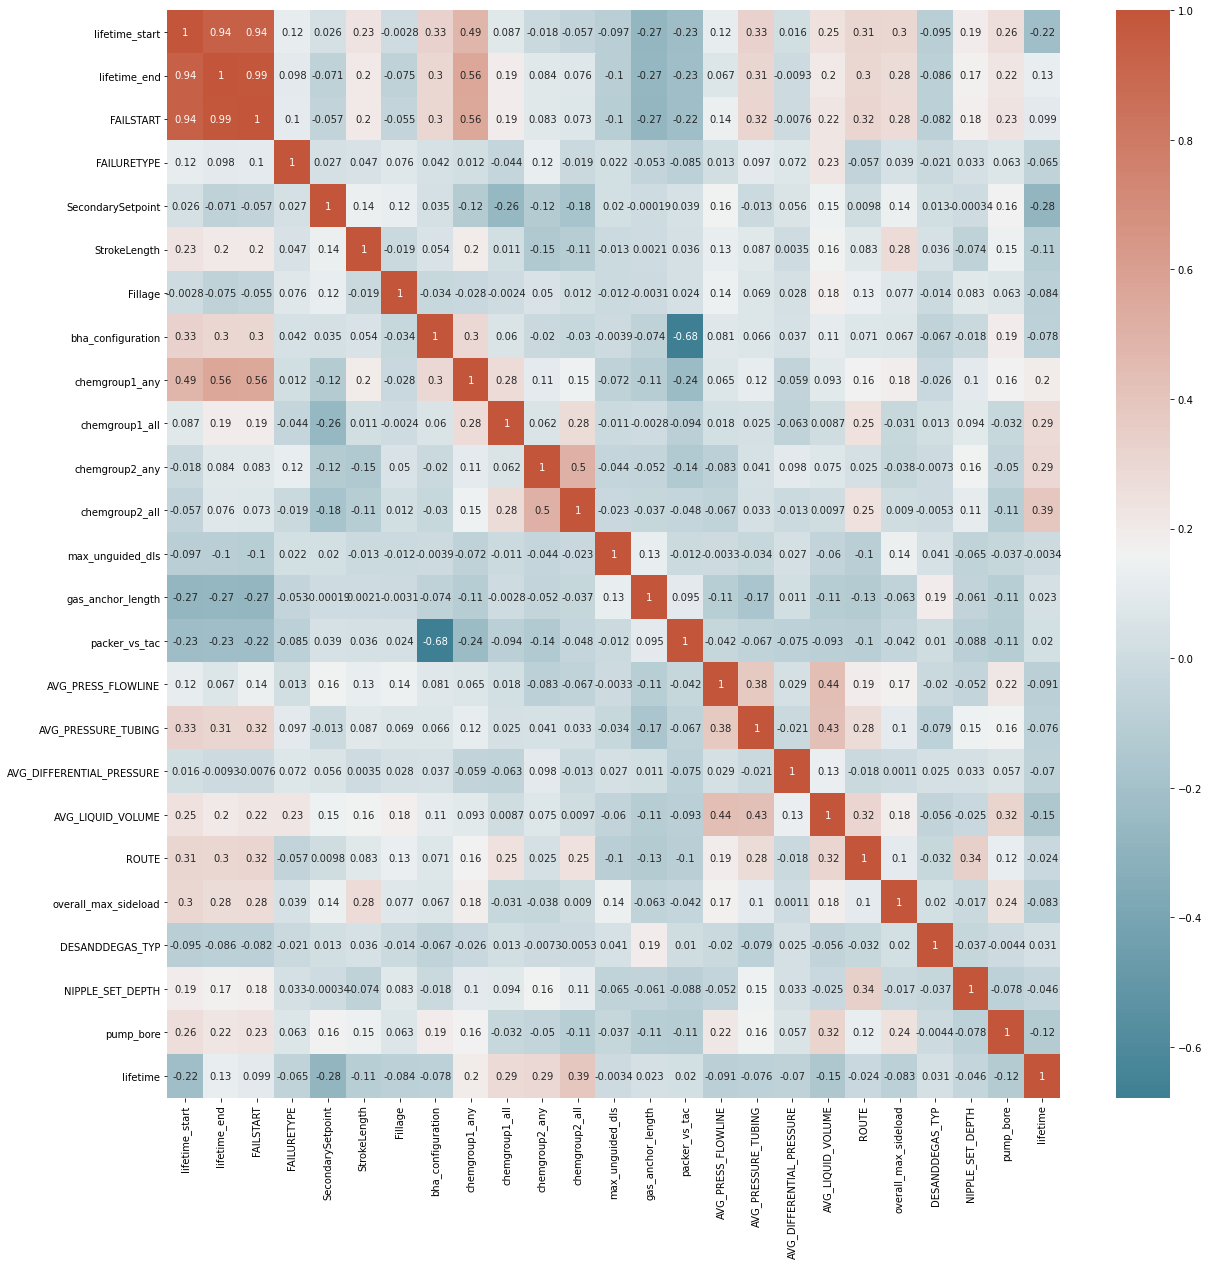

In [109]:
corr = rpdf_cleaned.corr()# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))


### Imputation

To fill the remaining missing values, we perform a K-nearest-neighbor imputation


In [9]:
imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputedR=pd.DataFrame(imputer.fit_transform(rpdf_cleaned))
imputedR.columns=rpdf_cleaned.columns


## Model Building

We begin constructing models by assigning a training and test set from the data. It is important that the training and test sets do not have any common data rows as this could affect the accuracy of our predictions. 70 percent of the cleaned data will be used for training while the remaining 30 percent will be used for testing.


In [10]:
X = imputedR.drop(['FAILSTART', 'lifetime_start', 'lifetime_end', 'lifetime'], axis=1)
y = rpdf_cleaned['lifetime']

#split the data again into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)


### GridSearch Cross Validation

We now perform a grid search cross validation and randomized search cross validation to determine the best hyperparameters for the model. Based on score data, we will be using the hyperparameters determined by grid search CV for our random forest regression.


In [11]:
param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}
rfr = RandomForestRegressor(random_state = 35)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 15}


In [12]:
g_search.best_score_

0.5308072506684852


### Linear Regression

We perform a multiple linear regression as a baseline estimate



Average error of 134.22103521260723 months


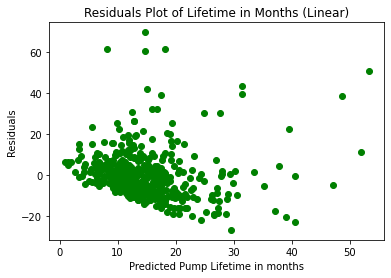

In [16]:
lr=LinearRegression()
y_train_months=y_train.copy()
y_train_months/=2.63002e+15
lr.fit(X_train,y_train_months)
prediction=lr.predict(X_test)
y_test_months=y_test.copy()
y_test_months/=2.63002e+15 #30.44 days per month
plt.scatter(prediction, y_test_months-prediction, color='green')
plt.xlabel('Predicted Pump Lifetime in months')
plt.ylabel('Residuals')
plt.title('Residuals Plot of Lifetime in Months (Linear)')
print()
print("Average error of",mean_squared_error(y_test_months, prediction), "months")

The residuals plot tells us that a linear model is not accurate in predicting pump life-spans


### Decision Tree Regression

We now try a different model that may give us better results



Average error of 116.89329140771277 months


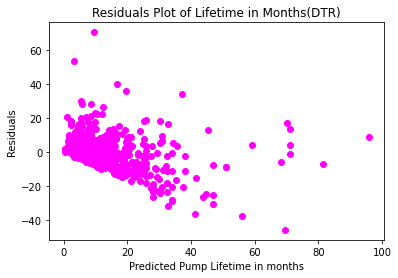

In [18]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train_months)
reg.score(X_test, y_test)
dtrPred=reg.predict(X_test)
plt.scatter(dtrPred, y_test_months-dtrPred, color='magenta')
plt.xlabel('Predicted Pump Lifetime in months')
plt.ylabel('Residuals')
plt.title('Residuals Plot of Lifetime in Months(DTR)')
print()
print("Average error of",mean_squared_error(y_test_months, dtrPred), "months")

Again, the residuals plot indicates that the chosen model does not predict pump lifetimes well


### Random Forest Regression

We now create our Random Forest model using the information provided by gridsearchcv


In [ ]:
rfr_random_reg = RandomForestRegressor(random_state = 35)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt', 'log2'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
r_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
print(r_grid)


### RandomizedSearchCV

We try a randomizedsearchcv to see if it will be better to use than the previous CV


In [47]:
rfr_random = RandomizedSearchCV(estimator=rfr_random_reg, param_distributions=r_grid, n_iter = 20, scoring='neg_mean_absolute_error', cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)
rfr_random.fit(X_train, y_train)
print(rfr_random.best_score_)
print(rfr_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
-1.7223865228292792e+16
{'n_estimators': 17, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}


In [48]:
print(rfr_random.score(X_test , y_test))

-1.5892720592239122e+16


The randomizedsearchcv appears to be less useful than gridsearchcv, so we will continue with gridsearch

### Weights

We now create a random forest regressor object and pass our training set to it. The following code displays the weights of each predictor variable in relation to their correlation with sucker rod pump lifespan.


<class 'numpy.ndarray'>
0 Feature: FAILURETYPE, Score: 0.01075
1 Feature: SecondarySetpoint, Score: 0.01246
2 Feature: StrokeLength, Score: 0.01386
3 Feature: Fillage, Score: 0.02504
4 Feature: bha_configuration, Score: 0.02793
5 Feature: chemgroup1_any, Score: 0.02976
6 Feature: chemgroup1_all, Score: 0.03119
7 Feature: chemgroup2_any, Score: 0.04066
8 Feature: chemgroup2_all, Score: 0.04112
9 Feature: max_unguided_dls, Score: 0.04224
10 Feature: gas_anchor_length, Score: 0.04351
11 Feature: packer_vs_tac, Score: 0.04680
12 Feature: AVG_PRESS_FLOWLINE, Score: 0.05272
13 Feature: AVG_PRESSURE_TUBING, Score: 0.05290
14 Feature: AVG_DIFFERENTIAL_PRESSURE, Score: 0.05875
15 Feature: AVG_LIQUID_VOLUME, Score: 0.05945
16 Feature: ROUTE, Score: 0.06826
17 Feature: overall_max_sideload, Score: 0.06864
18 Feature: DESANDDEGAS_TYP, Score: 0.07030
19 Feature: NIPPLE_SET_DEPTH, Score: 0.07929
20 Feature: pump_bore, Score: 0.12440


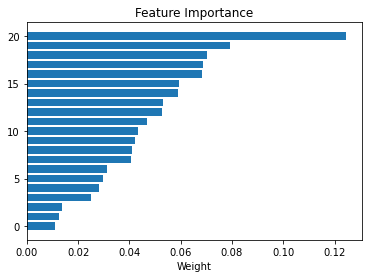

In [49]:
reg = RandomForestRegressor(bootstrap = True, max_depth = 30, max_features = 'sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators = 20)
reg.fit(X_train, y_train)
feature_names = list(X_train.columns)

importance = reg.feature_importances_
importance.sort()
print(type(importance))
# summarize feature importance
for i,v in enumerate(importance):
    if v < 1.0:
        print('%i Feature: %s, Score: %.5f' % (i,feature_names[i],v))
        
# plot feature importance
fig, ax = plt.subplots()

weightPlot = ax.barh(y=[x for x in range(len(importance))], width=importance)
#ax.set_yticklabels(imputedR.columns)
ax.set_xlabel('Weight')
ax.set_title('Feature Importance')

plt.show()


The code below determines that the mean error of our model is roughly .58 months


In [50]:
#score it up
predictions = reg.predict(X_test)

values = {'Predictions': predictions, 'Actual': y_test}
predictionsdf = pd.DataFrame(values, columns=['Predictions', 'Actual'])
predictionsdf['Predictions'] = predictionsdf['Predictions'].apply(pd.Timestamp)
predictionsdf['Actual'] = predictionsdf['Actual'].apply(pd.Timestamp)
predictionsdf['Error'] = predictionsdf['Actual'] - predictionsdf['Predictions']

predictionsdf['ErrorMonths'] = predictionsdf['Error'].dt.total_seconds()
predictionsdf['ErrorMonths'] = predictionsdf['ErrorMonths'].apply(lambda x: divmod(x, 86400*30)[0] )
predictionsdf['ErrorMonths'].mean(axis=0)

-0.8803088803088803


### Visualizing Results

We can finally visualize the results of our model through the following graphic.


In [51]:
# #and export so we can visualize what is going on
for k in range(12):
   dot_data = tree.export_graphviz(reg.estimators_[k+1], out_file='reggraph_' + str((k+1)), feature_names=X.columns, filled=True)